In [35]:
import math
import torch
import torch.nn as nn
device = torch.device('cuda:0')

In [36]:
%matplotlib inline

In [37]:
import torch
import numpy as np
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [38]:
transform = transforms.Compose(
             [transforms.ToTensor(),
             transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data',train=True,
                                        download=True,transform=transform)

trainloader = torch.utils.data.DataLoader(trainset,batch_size=30,num_workers=4,
                                          shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=30,num_workers=4,
                                         shuffle=False)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Files already downloaded and verified


In [39]:
def imshow(img):
    a = img/2 + 0.5
    npimg = a.numpy()
    plt.imshow(np.transpose(a,(1,2,0)))
    plt.show()

We show below 10 images of the dataset and then print the associated class

1667
torch.Size([30, 3, 32, 32])
tensor([1, 9, 0, 4, 0, 2, 7, 0, 2, 9, 8, 4, 7, 5, 6, 3, 8, 7, 8, 4, 4, 1, 6, 4,
        4, 4, 1, 3, 2, 1])


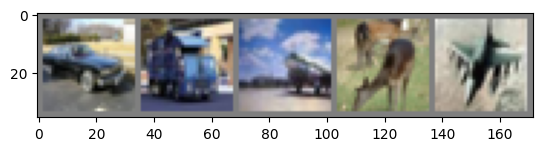

In [40]:
dataiter = iter(trainloader)
print(len(dataiter))
images,labels = next(dataiter)
print(images.shape)
print(labels)
imshow(torchvision.utils.make_grid(images[:5],nrow=5))


In [41]:
print(' '.join('%5s' % classes[labels[j]] for j in range(5)))

  car truck plane  deer plane


In [42]:
import torch.nn.functional as F

class ConvNet(nn.Module):

    def __init__(self):
        super(ConvNet,self).__init__()

        self.conv1 = nn.Conv2d(3,6,5)     # 3 is the nb of input channels(RGB image),
                                          # 6 is the desired number of output channels, 5 is the kernel size
        self.max_pool = nn.MaxPool2d(2,2) # reduces (again) the image size by taking the max over 2x2 patches
        self.conv2 = nn.Conv2d(6,16,5)
        self.fc1 = nn.Linear(16*5*5,120) # to understand why we use 16*5*5 take a look at the forward below
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        # we use 10 as the final number of neurons because there are 10 classes

    def forward(self,x):

        x = self.max_pool(F.relu(self.conv1(x)))
        x = self.max_pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x



In [43]:
CNet = ConvNet().to(device)

In [44]:
n_epochs = 100

In [45]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(CNet.parameters(),lr=0.001,momentum=0.9)

In [46]:
for ep in range(n_epochs):
    for i,x in enumerate(trainloader,0):
        image,label = x
        image = image.to(device)
        label = label.to(device)
        y_pred = CNet(image)
        loss = criterion(y_pred,label)



        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f'epoch {ep} loss {loss}')


epoch 0 loss 2.064042091369629
epoch 1 loss 1.408986210823059
epoch 2 loss 1.3499137163162231
epoch 3 loss 1.3613306283950806
epoch 4 loss 1.4909448623657227
epoch 5 loss 1.2409073114395142
epoch 6 loss 1.6316249370574951
epoch 7 loss 1.326096773147583
epoch 8 loss 1.1916897296905518
epoch 9 loss 1.1504429578781128
epoch 10 loss 1.3696767091751099
epoch 11 loss 1.5491790771484375
epoch 12 loss 1.0707529783248901
epoch 13 loss 0.8416967391967773
epoch 14 loss 0.948225200176239
epoch 15 loss 1.0947258472442627
epoch 16 loss 1.0234274864196777
epoch 17 loss 0.7743264436721802
epoch 18 loss 0.9271634817123413
epoch 19 loss 0.8346477746963501
epoch 20 loss 1.137033224105835
epoch 21 loss 0.6449247598648071
epoch 22 loss 0.7009150981903076
epoch 23 loss 0.8716145753860474
epoch 24 loss 0.650748610496521
epoch 25 loss 1.075698971748352
epoch 26 loss 0.8052145838737488
epoch 27 loss 0.849300742149353
epoch 28 loss 0.8349050283432007
epoch 29 loss 1.0030978918075562
epoch 30 loss 0.589488208293

KeyboardInterrupt: ignored

We compute the global accuracy of the model (61%):

In [47]:
correct = 0
total = 0
with torch.no_grad():

    for i,batch in enumerate(testloader):
        images,label = batch
        images,label = images.to(device),label.to(device)
        prediction = CNet(images)  #recall that prediction is a tensor of shape B x N_Classes
        maximum,pred_indices = torch.max(prediction,dim=1)
        c = (pred_indices == label)
        correct += c.sum().item()
        total += label.size(0)
    print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))









Accuracy of the network on the 10000 test images: 61 %


We compute the accuracy for each of the 10 classes by counting the number of occurence of each class and counting how many times each class was predicted correctly:

In [48]:

correct_pred = {classname:0 for classname in classes}
total_pred = {classname:0 for classname in classes}

with torch.no_grad():
    for data in testloader:
        images,labels = data
        pred = CNet(images.to(device))
        max,pred_indices = torch.max(pred,dim=1)
        for label,prediction in zip(labels,pred_indices):
            if label==prediction:
                correct_pred[classes[label]]+=1
            total_pred[classes[label]]+=1




In [52]:
for classname,count in correct_pred.items():
  accuracy = 100*(count/total_pred[classname])
  print(f'The accuracy of class {classname} is {accuracy}')

The accuracy of class plane is 66.9
The accuracy of class car is 74.4
The accuracy of class bird is 49.0
The accuracy of class cat is 44.1
The accuracy of class deer is 53.2
The accuracy of class dog is 53.400000000000006
The accuracy of class frog is 75.4
The accuracy of class horse is 56.3
The accuracy of class ship is 73.4
The accuracy of class truck is 67.9
